## Project

**Calculates the temperature field of air/nitrogen between furnace and fuel during BHASMA fuel combustion study**

**Sources for Constants** 

- https://www.engineeringtoolbox.com/air-properties-viscosity-conductivity-heat-capacity-d_1509.html
- https://www.engineeringtoolbox.com/air-specific-heat-capacity-d_705.html
- https://www.omnicalculator.com/physics/air-density
- https://www.engineeringtoolbox.com/air-prandtl-number-viscosity-heat-capacity-thermal-conductivity-d_2009.html
- https://www.engineeringtoolbox.com/nitrogen-N2-dynamic-kinematic-viscosity-temperature-pressure-d_2067.html
- https://www.engineeringtoolbox.com/nitrogen-N2-thermal-conductivity-temperature-pressure-d_2084.html
- 

Grid: x=11, y=31
m: 300


C:\Users\mojosulo\AppData\Local\Temp\ipykernel_21200\778332649.py:244: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

C:\Users\mojosulo\AppData\Local\Temp\ipykernel_21200\778332649.py:250: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



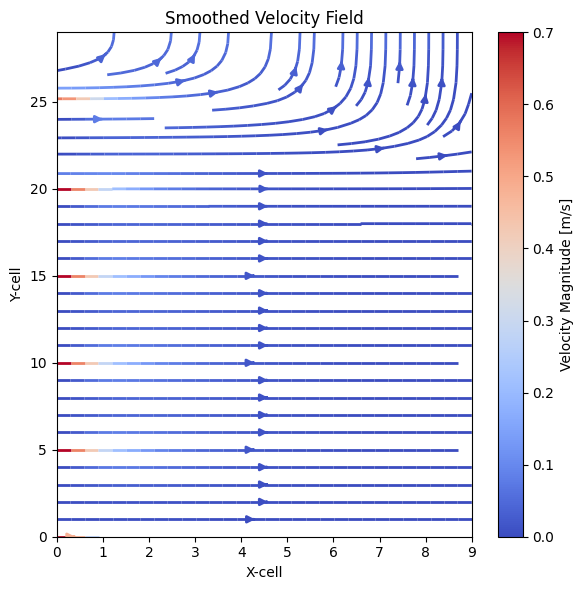

<Figure size 640x480 with 0 Axes>

In [297]:
import numpy as np
import plotly.graph_objs as go
import plotly.io as pio

# Material Constants
rho = 0.383  # kg/m3 at 85kpa and 500 C
c_p = 1092   #W/kgk engineering toolbok at 500C
k = 0.05579     # engineering toolbox at 500C
Pr = .715
Re = 1e5
Nu = .0296*Re**(.8)*Pr**(.333)
k_nitro = 0.02579     # engineering toolbox at 500C

# q = 38240  # kW/m2 applied flux
area_cx = np.pi/4*(.2)**2
v_dot = .040/60  #m^3/sec
u = v_dot/area_cx  # Face velocity out of chamber
u_N2 = .7   # Velocity of nitrogen orifices
u_basket = .001  # Velocity of updraft at basket boundry

h_side = 25
h_bottom = 0
h_top = 25
T_amb = 25
T_wall = 500
T_basket = 25
T_N2 = 10

# Parameters
rectangle_width = .051   # Width of the rectangle (m)
rectangle_height = .152   # Height of the rectangle (m)
dx = .0051 # Cell size in the x-direction (m)
dy = .0051  # Cell size in the y-direction (m)


# Create the grid
x = np.arange(0, rectangle_width + dx, dx)
y = np.arange(0, rectangle_height + dy, dy)
print(f'Grid: x={x.size}, y={y.size}')
a = y.size - 1
b = x.size - 1

# Generate the coordinates for the cell centers
x_cell_centers = (x[:-1] + x[1:]) / 2
y_cell_centers = (y[:-1] + y[1:]) / 2

# Create a meshgrid for cell centers
X_cell_centers, Y_cell_centers = np.meshgrid(x_cell_centers, y_cell_centers)

m = X_cell_centers.size  # Number of elements
print(f'm: {m}')
mx = len(x)  # Number of grid points in a row
my = len(y)  # Number of grid points in a coluprintprintmn


# Initialize Matrices
Q = np.zeros((len(y_cell_centers), len(x_cell_centers)))  # Temp matrix!

# Generate Mapping Matrix
M = np.zeros((m, 4), dtype=int)
F = m*[0]
F = np.zeros((m, 1))
T = m*[0]
T = np.zeros((m, 1))
ux = m*[0]
ux = np.zeros((m, 1))
uy = m*[0]
uy = np.zeros((m, 1))
dT = m*[0]
dT = np.zeros((m, 1))

# Mapping Matrix
for j in range(m):
    #E = -1
    #N = -2
    #W = -3
    #S = -4

    E = j + 1
    N = j + 10
    W = j - 1
    S = j - 10

    if (j % 10) == 9:  # right BC
        E = -1
    if j >= m-10:  # Top BC
        N = -2
    if (j % 10) == 0:  # Left BC
        W = -3
        # if (j / 10) % 5 == 0:  #every fifth row
        #     W = -5
    if j <= 9:  # Bottom BT
        S = -4

    M[j][0] = int(E)    # East
    M[j][1] = int(N)    # North
    M[j][2] = int(W)    # West
    M[j][3] = int(S)    # South



# Velocity matrix
Vx = np.zeros((a,b))  # x-component of velocity
Vy = np.zeros((a,b))  # y-component of velocity


Vx[0, :] = 0  # Top boundary 
Vx[-1, :] = 0  # Bottom boundary 
Vx[::5, 0] = u_N2  # Left boundary 
Vx[:, -1] = 0  # Right boundary 


Vy[0, :] = 0  # Top boundary 
Vy[-1, :] = u  # Bottom boundary 
Vy[:, 0] = 0  # Left boundary 
Vy[:, -1] = u_basket  # Right boundary 


def interpolate_velocity(V):
    a, b = V.shape
    for i in range(1, a - 1):
        for j in range(1, b - 1):
            V[i, j] = (V[i-1, j] + V[i+1, j] + V[i, j-1] + V[i, j+1]) / 4
    return V

# Interpolate both Vx and Vy
Vx = interpolate_velocity(Vx)
Vy = interpolate_velocity(Vy)

# Step 4: Smoothing using a simple relaxation method (finite difference)
# Apply relaxation for both Vx and Vy components

def smooth_velocity_field(Vx, Vy, iterations=10):
    a, b = Vx.shape
    for _ in range(iterations):
        Vx_new = Vx.copy()
        Vy_new = Vy.copy()
        
        # Smooth Vx (x-component)
        for i in range(1, a - 1):
            for j in range(1, b - 1):
                Vx_new[i, j] = (Vx[i-1, j] + Vx[i+1, j] + Vx[i, j-1] + Vx[i, j+1]) / 4
        
        # Smooth Vy (y-component)
        for i in range(1, a - 1):
            for j in range(1, b - 1):
                Vy_new[i, j] = (Vy[i-1, j] + Vy[i+1, j] + Vy[i, j-1] + Vy[i, j+1]) / 4
        
        # Update the fields after smoothing
        Vx = Vx_new
        Vy = Vy_new
    
    return Vx, Vy

# Smooth both Vx and Vy fields
Vx_smooth, Vy_smooth = smooth_velocity_field(Vx, Vy)

u_mag = np.sqrt(Vx_smooth**2 + Vy_smooth**2)

u_mag_vec = u_mag.flatten()




# Flux Calculation
def flux_calc(F, M, T, U):
    ''' F is the flux matrix, M is mapping matrix, units of K/s
        Meaning that rho*cp are included here instead of later so units are T_dot really
    '''
    for i in range(m):
        F[i] = 0.0
        for j in range(4):
            J = M[i][j]
            dT[i] = T[J]-T[i]
            if np.any(np.isnan(U)) or np.any(np.isnan(T)):
                print("NaN values detected in initial U or T.")

            # print(U[i]*T[i])
            # print(T[i])
            if J == -1:  # right side
                F[i] = F[i] - U[i]*T[i]/dx
                # F[i] = F[i] + -h*(T[i]-T_N2)
            elif J == -2:  # top side
                F[i] = F[i] - U[i]*T[i]/dx
                # F[i] = F[i] + -h*(T[i]-T_N2)
            elif J == -3:  # left side
                # F[i] = F[i] + -h_side*(T[i]-25)
                F[i] = F[i] + -k*(T[i] - T_wall)/(dx*dx*rho*c_p) - (U[i]*T_N2)/dx #+ -h*(T[i]-T_N2)
            elif J == -4:  # bottom side
                F[i] = F[i]
                # F[i] = F[i] + -h*(T[i]-T_N2)
            # elif J == -5:  # bottom side
            #     # F[i] = F[i]
            #     F[i] = F[i] + 0
            else:  # inner cells
                F[i] = F[i] + k*(T[J]-T[i])/(dx*dx*rho*c_p) #- U[i]*(18/4)
                F[i] = F[i] + U[i]*(T[J] - T[i])/dx
                # F[i] = F[i] + U[i]*(T[i])/(4*dx)
                # print(T[J] - T[i])
    return F



# RK4 or Euler for solving for temperature field
def temp_calc(F, T, M, U, end_sec, dt, runga=True):
    steps = int(end_sec / dt)
    for t in range(steps):
        if runga:
            F1 = flux_calc(F, M, T, U)
            k1 = 1/(1)*F1
            F2 = flux_calc(F, M, (T + k1*dt/2), U)
            k2 = 1/(1)*F2
            F3 = flux_calc(F, M, (T + k2*dt/2), U)
            k3 = 1/(1)*F3
            F4 = flux_calc(F, M, (T + k3*dt), U)
            k4 = 1/(1)*F4

            T += (k1 + 2*k2 + 2*k3 + k4)/6*dt
        else:
            F = flux_calc(F, M, T, U)
            T += 1/(1)*F*dt

    return T






# Function calls and Plotting
F = flux_calc(F, M, T, u_mag_vec)  #initialize flux BC

dt = .004
secs = [1, 2, 3, 4, 5, 7, 10, 20]
for end_sec in secs:
    T = temp_calc(F, T, M, u_mag_vec, end_sec, dt, runga=False)


    F2 = np.zeros_like(Q)
    for i,val in enumerate(F):
        row = int(np.floor(i / 10))
        col = (i % 10)
        F2[row][col] = val

    T2 = np.zeros_like(Q)
    for i,val in enumerate(T):
        row = int(np.floor(i / 10))
        col = (i % 10)
        T2[row][col] = val

    # T2.reshape(x,y)


    ##### PLOTING ######

    Z = X_cell_centers**2 + Y_cell_centers**2  

    contour = go.Contour(
        x=x_cell_centers,
        y=y_cell_centers,
        z=T2,
        colorscale='Inferno',  
        colorbar=dict(title='Temperature [°C]'),  
        contours=dict(
            start=0,  
            end=T2.max(),    #
            size=(T2.max() - T2.min()) / 15  
        )
    )

    fig = go.Figure(data=contour)
    fig.add_trace(go.Scatter(x=[dx/2, rectangle_width-(dx/2)], y=[.05, .05], mode='lines', showlegend=False, line=dict(width=3, color='black')))
    fig.add_trace(go.Scatter(x=[dx/2, rectangle_width-(dx/2)], y=[.145, .145], mode='lines', showlegend=False, line=dict(width=3, color='black')))
    # fig.add_trace(go.Scatter(x=[dx/2, rectangle_width-(dx/2)], y=[rectangle_height-dx/2, rectangle_height-dx/2], mode='lines', showlegend=False, line=dict(width=3, color='black')))

    # Update layout
    fig.update_layout(
        title=f'Temperature field at t = {end_sec} sec',
        xaxis_title='X-axis [m]',
        yaxis_title='Y-axis [m]',
        width=600,  # Set width in pixels
        height=1000,  # Set height in pixels
        yaxis_range = [y_cell_centers[0], y_cell_centers[-1]],
    )

    fig.show()
    pio.write_image(fig, f'Proj_T_{end_sec}s_{u:.3f}_{u_N2}_{u_basket}_{dt}.png')



## Velocity 
plt.figure(figsize=(6, 6))

# Original velocity field (after interpolation)

# Smoothed velocity fiel
strm_smooth = plt.streamplot(np.arange(b), np.arange(a), Vx_smooth, Vy_smooth, color=u_mag, linewidth=2, cmap='coolwarm')
plt.title('Smoothed Velocity Field')
plt.xlabel('X-cell')
plt.ylabel('Y-cell')
plt.xlim(0, b-1)
plt.ylim(0, a-1)
cbar = plt.colorbar(strm_smooth.lines)  # Add color bar for smoothed velocity field
cbar.set_label('Velocity Magnitude [m/s]')  # Label for the color bar

plt.tight_layout()
plt.show()
plt.savefig(f'Proj_u_{u:.3f}_{u_N2}_{u_basket}.png', format='png')



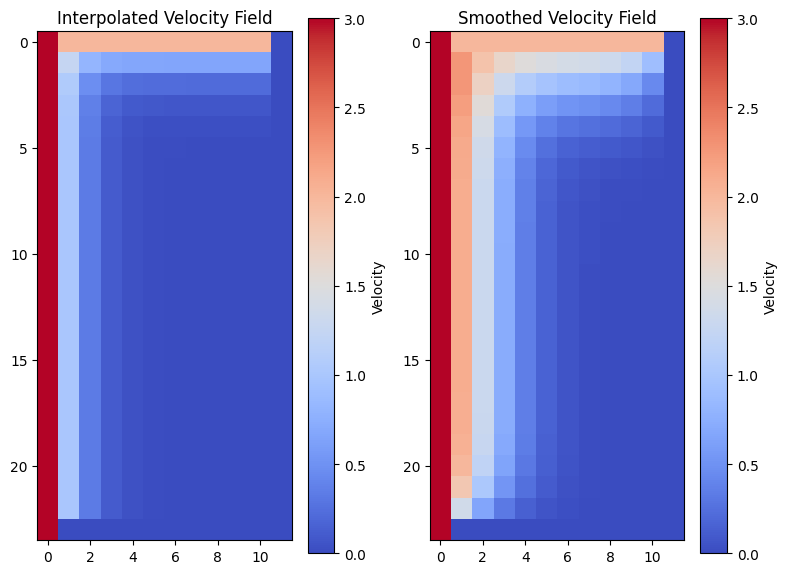

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid size
m, n = 24, 12  # For a 6x6 grid

# Initialize the velocity matrix
V = np.zeros((m, n))

# Set boundary conditions (left, right, top, bottom)
V[0, :] = 2  # Top boundary (constant velocity)
V[-1, :] = 0  # Bottom boundary (constant velocity)
V[:, 0] = 3  # Left boundary (constant velocity)
V[:, -1] = 0  # Right boundary (constant velocity)

# Step 3: Interpolation to fill interior points (linear interpolation)
# We'll use linear interpolation between boundary points (just for the sake of simplicity)

# Interior points will be interpolated linearly from the borders
for i in range(1, m - 1):
    for j in range(1, n - 1):
        V[i, j] = (V[i-1, j] + V[i+1, j] + V[i, j-1] + V[i, j+1]) / 4

# Step 4: Smoothing using a simple relaxation method (finite difference)
# Apply relaxation for a few iterations to smooth out the field

def smooth_velocity_field(V, iterations=10):
    m, n = V.shape
    for _ in range(iterations):
        V_new = V.copy()
        for i in range(1, m - 1):
            for j in range(1, n - 1):
                V_new[i, j] = (V[i-1, j] + V[i+1, j] + V[i, j-1] + V[i, j+1]) / 4
        V = V_new
    return V

# Smooth the velocity field
V_smooth = smooth_velocity_field(V)

# Plotting the results for visualization
plt.figure(figsize=(8, 6))

# Original velocity field (after interpolation)
plt.subplot(1, 2, 1)
plt.imshow(V, cmap='coolwarm', interpolation='nearest')
plt.title('Interpolated Velocity Field')
plt.colorbar(label='Velocity')

# Smoothed velocity field
plt.subplot(1, 2, 2)
plt.imshow(V_smooth, cmap='coolwarm', interpolation='nearest')
plt.title('Smoothed Velocity Field')
plt.colorbar(label='Velocity')

plt.tight_layout()
plt.show()


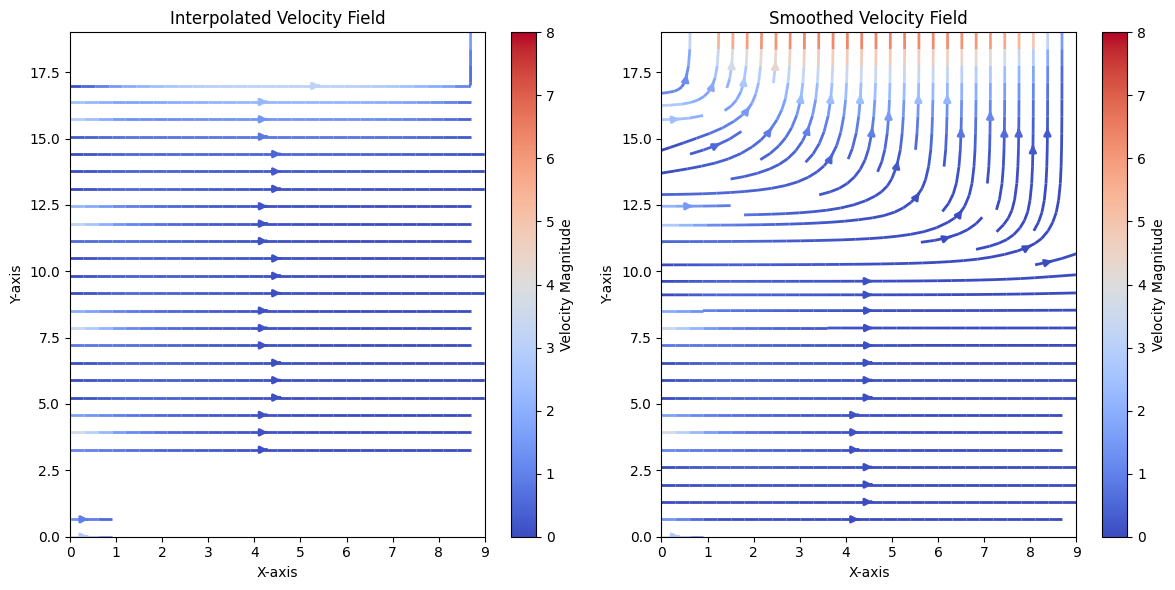

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Define grid size
m, n = 20, 10  # For a 6x6 grid

# Initialize the velocity matrices for x and y components
Vx = np.zeros((m, n))  # x-component of velocity
Vy = np.zeros((m, n))  # y-component of velocity


Vx[0, :] = 0  # Top boundary (constant velocity in x direction)
Vx[-1, :] = 0  # Bottom boundary (constant velocity in x direction)
Vx[::4, 0] = 4  # Left boundary (constant velocity in x direction)
Vx[:, -1] = 0  # Right boundary (constant velocity in x direction)

# For Vy (y-component of velocity)
Vy[0, :] = 0  # Top boundary (constant velocity in y direction)
Vy[-1, :] = 8  # Bottom boundary (constant velocity in y direction)
Vy[:, 0] = 0  # Left boundary (constant velocity in y direction)
Vy[:, -1] = 0  # Right boundary (constant velocity in y direction)

# Step 3: Interpolation to fill interior points (linear interpolation)
# We'll interpolate linearly from the boundary points for both Vx and Vy

def interpolate_velocity(V):
    m, n = V.shape
    for i in range(1, m - 1):
        for j in range(1, n - 1):
            V[i, j] = (V[i-1, j] + V[i+1, j] + V[i, j-1] + V[i, j+1]) / 4
    return V

# Interpolate both Vx and Vy
Vx = interpolate_velocity(Vx)
Vy = interpolate_velocity(Vy)

# Step 4: Smoothing using a simple relaxation method (finite difference)
# Apply relaxation for both Vx and Vy components

def smooth_velocity_field(Vx, Vy, iterations=10):
    m, n = Vx.shape
    for _ in range(iterations):
        Vx_new = Vx.copy()
        Vy_new = Vy.copy()
        
        # Smooth Vx (x-component)
        for i in range(1, m - 1):
            for j in range(1, n - 1):
                Vx_new[i, j] = (Vx[i-1, j] + Vx[i+1, j] + Vx[i, j-1] + Vx[i, j+1]) / 4
        
        # Smooth Vy (y-component)
        for i in range(1, m - 1):
            for j in range(1, n - 1):
                Vy_new[i, j] = (Vy[i-1, j] + Vy[i+1, j] + Vy[i, j-1] + Vy[i, j+1]) / 4
        
        # Update the fields after smoothing
        Vx = Vx_new
        Vy = Vy_new
    
    return Vx, Vy

# Smooth both Vx and Vy fields
Vx_smooth, Vy_smooth = smooth_velocity_field(Vx, Vy)

# Calculate the velocity magnitude (for coloring purposes)
velocity_magnitude = np.sqrt(Vx_smooth**2 + Vy_smooth**2)

# Plotting the results for visualization
plt.figure(figsize=(12, 6))

# Original velocity field (after interpolation)
plt.subplot(1, 2, 1)
strm = plt.streamplot(np.arange(n), np.arange(m), Vx, Vy, color=velocity_magnitude, linewidth=2, cmap='coolwarm')
plt.title('Interpolated Velocity Field')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim(0, n-1)
plt.ylim(0, m-1)
cbar = plt.colorbar(strm.lines)  # Add color bar for interpolated velocity field
cbar.set_label('Velocity Magnitude')  # Label for the color bar

# Smoothed velocity field
plt.subplot(1, 2, 2)
strm_smooth = plt.streamplot(np.arange(n), np.arange(m), Vx_smooth, Vy_smooth, color=velocity_magnitude, linewidth=2, cmap='coolwarm')
plt.title('Smoothed Velocity Field')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim(0, n-1)
plt.ylim(0, m-1)
cbar = plt.colorbar(strm_smooth.lines)  # Add color bar for smoothed velocity field
cbar.set_label('Velocity Magnitude')  # Label for the color bar

plt.tight_layout()
plt.show()

